# Exercise Sheet 8: Generative Adversarial Networks
## Task 1: Optimal Discriminator and Generator

The minmax game can be represented with the formula below:
$$
V(D,G)=\mathbb{E}_{x\thicksim p_{data}(x)}\left[\log\left(D\left(x\right)\right)\right]+\mathbb{E}_{z\thicksim p(z)}\left[\log\left(1-D\left(G\left(z\right)\right)\right)\right]
$$

>The goal of the first task is to derive the **optimal discriminator** and **generator** from scratch.
> 1. Use this equation as a starting point to derive the optimal discriminator $D*$ in terms of data probability $p_{data}(x)$ and generator probability $p_G(x)$. Assume generator G is fixed.

- $p_{data}(x)$ is the probability distribution of the real data.
- $p_G(x)$ id the probability distribution of the generated data, where $x = G(z)$ with $z$ is sampled from $p_z(z)$

$$
\begin{gathered}
V(G,D) =\int_{\boldsymbol{x}}p_{\mathrm{data}}(\boldsymbol{x})\log(D(\boldsymbol{x}))dx+\int_{\boldsymbol{z}}p_{\boldsymbol{z}}(\boldsymbol{z})\log(1-D(g(\boldsymbol{z})))dz \\
=\int_{\boldsymbol{x}}p_{\mathrm{data}}(\boldsymbol{x})\log(D(\boldsymbol{x}))+p_G(\boldsymbol{x})\log(1-D(\boldsymbol{x}))dx 
\end{gathered}
$$

To find the optimal discriminator $D*$, we now need to to maximize $V(G, D)$ with respect to D and set it to zero.

$$
f(D(x)) = p_{data}(x)\log(D(x)) + p_G(x)\log(1-D(x))
$$
Thus,
$$
\begin{gathered}
\frac{\partial f(D(x))}{\partial D(x)}=\frac{p_{data}(x)}{D(x)}-\frac{p_G(x)}{1-D(x)}=0 \\
\iff \frac{p_{data}(x)}{D(x)}=\frac{p_G(x)}{1-D(x)} \\
\iff p_{data}(x)=D(x)(p_{data}(x)+p_G(x)) \\
\iff D^*(\boldsymbol{x})=\frac{p_{data}(\boldsymbol{x})}{p_{data}(\boldsymbol{x})+p_G(\boldsymbol{x})}
\end{gathered}
$$




> 2. Use the obtained $D*$ to find the optimal point minimizing V . Please include all necessary steps to get to the final results in your report.

We can substitute $D$ by $D*$ in the original function:

$$
V(D*,G)=\mathbb{E}_{x\thicksim p_{data}(x)}\left[\log\left(\frac{p_{data}(\boldsymbol{x})}{p_{data}(\boldsymbol{x})+p_G(\boldsymbol{x})}\left(x\right)\right)\right]+\mathbb{E}_{z\thicksim p(z)}[\log(1-\frac{p_{data}(\boldsymbol{x})}{p_{data}(\boldsymbol{x})+p_G(\boldsymbol{x})}]
$$
Simce the the two expressions are over the same domain:
$$
V(D^*,G)=\int_xp_{data}(x)\log\left(\frac{p_{data}(x)}{p_{data}(x)+p_G(x)}\right)dx+\int_xp_G(x)\log\left(\frac{p_G(x)}{p_{data}(x)+p_G(x)}\right)
$$

In the case the generator perfectly replicates the data distribution: $p_{data}(x) = p_G(x)$

Thus, in this case the optimal discriminator will be equal to:
$$D^*(x)=\frac{p_{data}(x)}{p_{data}(x)+p_G(x)}=\frac{p_{data}(x)}{2p_{data}(x)}=\frac12$$

Thus, we can reformulate the minmax game like this and plug in $D^*$:

$$
\begin{aligned}
V(D_G^*,G)=& \max_DV(G,D^*_G)  \\
=& \mathbb{E}_{\boldsymbol{x}\thicksim p_{\mathrm{data}}}[\log D_G^*(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z}\thicksim p_{\boldsymbol{z}}}[\log(1-D_G^*(G(\boldsymbol{z})))]  \\
=& \mathbb{E}_{\boldsymbol{x}\sim p_{\mathrm{data}}}[\log D_G^*(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{x}\sim p_g}[\log(1-D_G^*(\boldsymbol{x}))]  \\
=& \mathbb{E}_{\boldsymbol{x}\thicksim p_{\mathrm{data}}}\left[\log\frac{p_{\mathrm{data}}(\boldsymbol{x})}{P_{\mathrm{data}}(\boldsymbol{x})+p_g(\boldsymbol{x})}\right]\boldsymbol{+}\mathbb{E}_{\boldsymbol{x}\thicksim p_g}\left[\log\frac{p_g(\boldsymbol{x})}{p_{\mathrm{data}}(\boldsymbol{x})+p_g(\boldsymbol{x})}\right] \\

\text{with  } \log\frac12+\log\frac12=-\log4 \\

=& -\log(4) + \mathbb{E}_{\boldsymbol{x}\sim p_{\mathrm{data}}}\left[-\log2\right]+\mathbb{E}_{\boldsymbol{x}\sim p_{g}}\left[-\log2\right] \\
=& -\log(4)+KL\left(p_\text{data}\left\|\frac{p_\text{data}+p_g}2\right)+KL\left(p_g\left\|\frac{p_\text{data}+p_g}2\right.\right)\right. \\
=& -\log(4)+2\cdot JSD\left(p_{\mathrm{data}}\left\|p_{g}\right.\right)
\end{aligned}
$$

> What value does $D*$ have at this point and what would this value imply?

This implies that the **discriminator cannot distinguish between real and generated data** at the optimal point, which is the goal of training a GAN.

Note:
If you’re stuck, take a look at the seminal paper Generative Adversarial Nets by
Goodfellow et al 2

We are loading the MNIST dataset via torchvision.

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils as vutils
from cnn import train_cnn
from gan import Discriminator, Generator, get_device, train
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from torch import nn, optim
from torchvision import datasets, transforms

In [20]:
def get_device():
    if torch.backends.mps.is_built(): return "mps"
    if torch.cuda.is_available(): return "cuda"
    return "cpu"
device = torch.device(get_device())

In [21]:
image_size = 32
dataroot = "./data"
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ]
)

train_dataset = datasets.FashionMNIST(
    root=dataroot, train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.FashionMNIST(
    root=dataroot, train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]




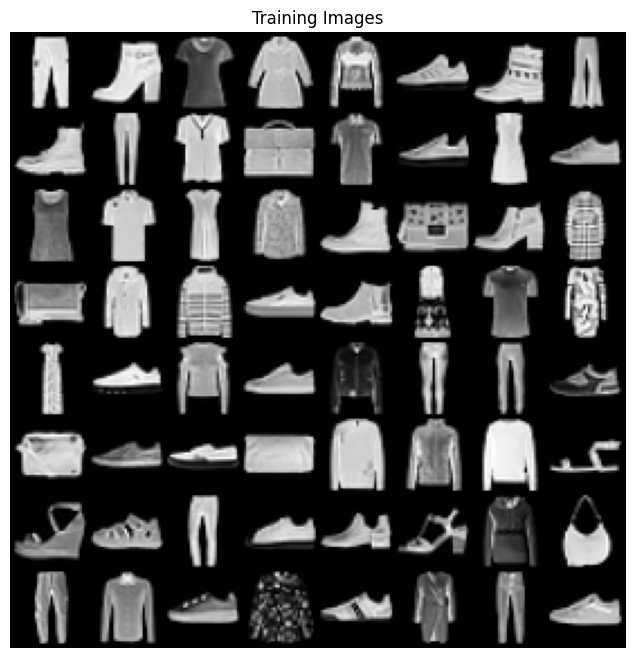

In [22]:
data_iter = next(iter(train_loader))
images, labels = data_iter

image_grid = vutils.make_grid(images)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(image_grid.permute(1, 2, 0).numpy())
plt.show()

[Epoch 0/2] [D loss: 0.670457661151886] [G loss: 0.6517575979232788]


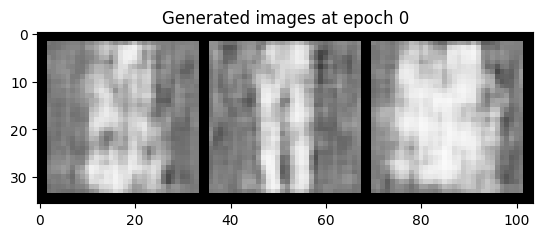

[Epoch 1/2] [D loss: 0.6382706165313721] [G loss: 0.7961627244949341]


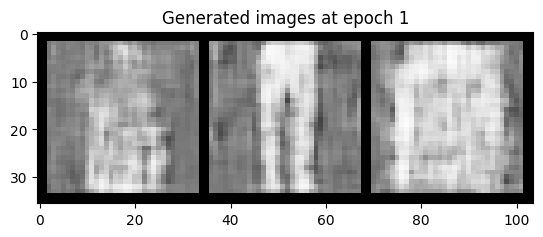

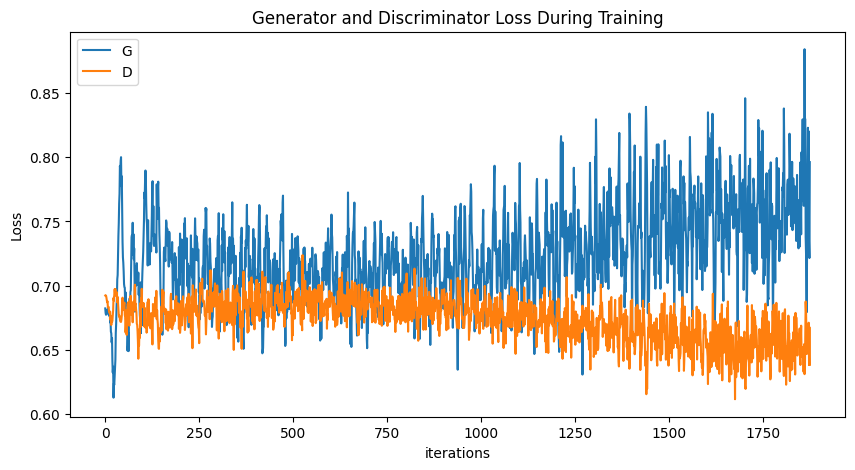

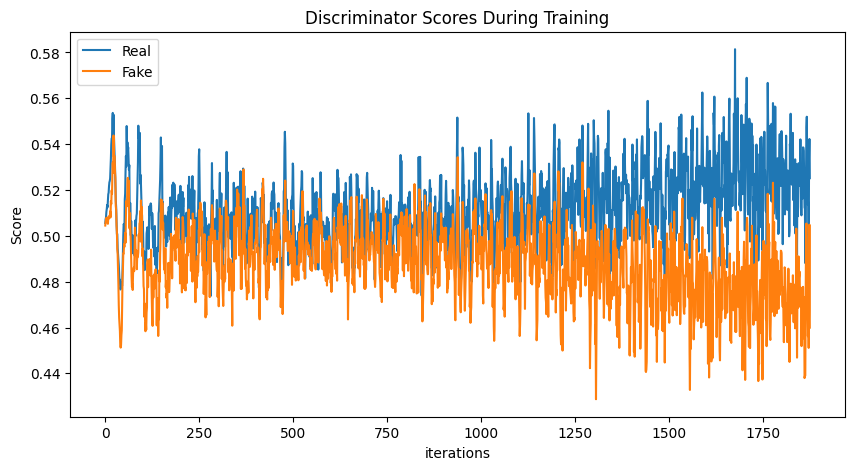

In [27]:
generator, discriminator = train(device, train_loader)

Epoch [1/10], Loss: 1.8731003094837864
Epoch [2/10], Loss: 1.3103855168387326
Epoch [3/10], Loss: 1.169242938063038
Epoch [4/10], Loss: 1.09341583729807
Epoch [5/10], Loss: 1.0350434882427328
Epoch [6/10], Loss: 0.985652967175441
Epoch [7/10], Loss: 0.9474217429725346
Epoch [8/10], Loss: 0.9150098567324152
Epoch [9/10], Loss: 0.8840494183843324
Epoch [10/10], Loss: 0.8610368098404362


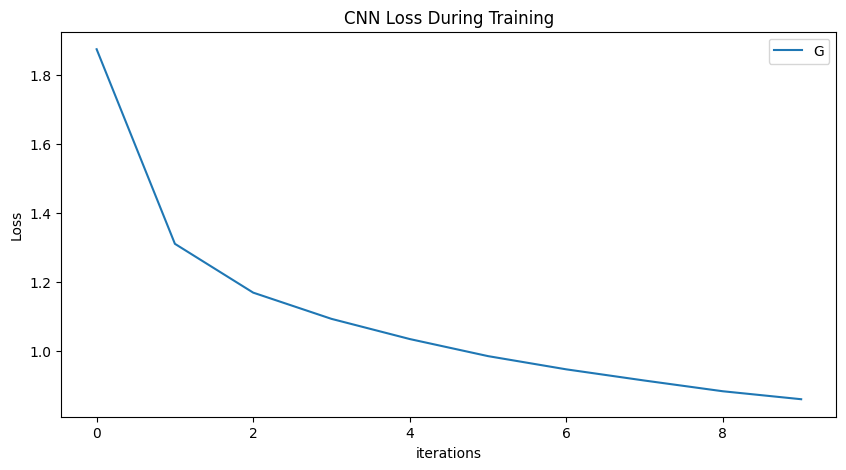

Accuracy on test set: 68.47%


In [ ]:
classifier = train_cnn()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class GeneratedDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx]
        return img, label

# Function to generate images using the trained GAN
def generate_images(generator, latent_dim, num_classes, num_images_per_class):
    generated_images = []
    device = get_device()
    
    for label in range(num_classes):
        fixed_noise = torch.randn(num_images_per_class, latent_dim).to(device)
        fixed_labels = torch.tensor([label] * num_images_per_class).to(device)
        with torch.no_grad():
            imgs = generator(fixed_noise, fixed_labels)
            imgs = imgs * 0.5 + 0.5  # Unnormalize to [0, 1]
            
            for img in imgs:
                generated_images.append((img, label))
    
    return GeneratedDataset(generated_images)

# Generate images for selected classes and create a DataLoader
latent_dim = 100
num_classes = 10
num_images_per_class = 500

generated_dataset = generate_images(generator, latent_dim, num_classes, num_images_per_class)
generated_loader = DataLoader(generated_dataset, batch_size=32, shuffle=True)


In [ ]:
# Function to extract features
def extract_features(model, dataloader):
    features = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
    return np.array(features)

# Extract features from train and test datasets
train_features = extract_features(classifier, train_loader)
test_features = extract_features(classifier, test_loader)
generated_features = extract_features(classifier, generated_loader)

print("Feature extraction completed.")

Feature extraction completed.


In [ ]:
print(train_features.shape)
print(test_features.shape)
print(generated_features.shape)

(60000, 32)
(10000, 32)
(5000, 32)


### t-SNE on features of train set

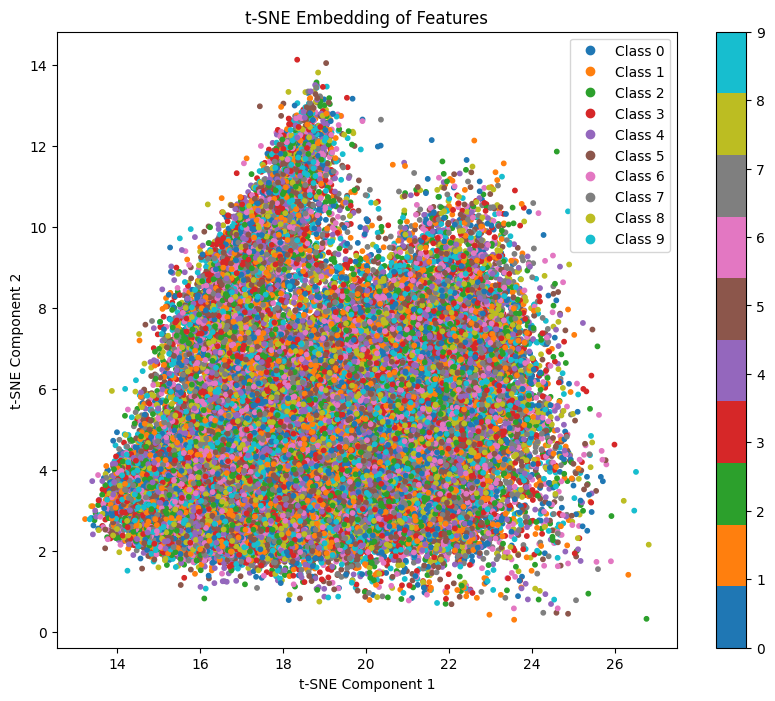

In [ ]:

# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(train_features)


# Plot t-SNE embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_features[:, 0], train_features[:, 1], c=train_dataset.targets, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Class {i}' for i in range(num_classes)])
plt.title('t-SNE Embedding of Features')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter)
plt.show()

It was just working with the last GAN trained on 2 epoch 🤦‍♂️

### t-SNE on features of test set

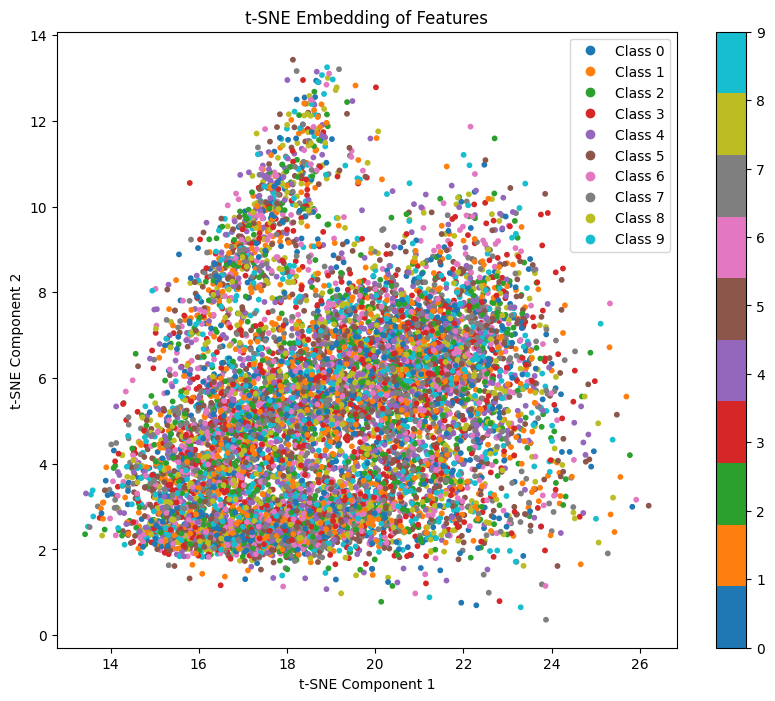

In [ ]:

# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(test_features)


# Plot t-SNE embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(test_features[:, 0], test_features[:, 1], c=test_dataset.targets, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Class {i}' for i in range(num_classes)])
plt.title('t-SNE Embedding of Features')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter)
plt.show()

### t-SNE on features of generated set

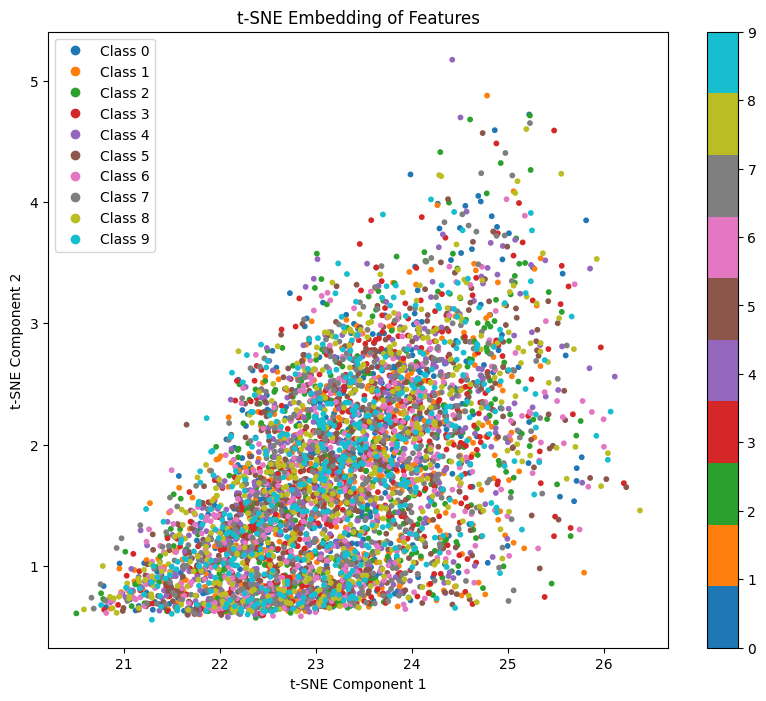

In [ ]:

# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(generated_features)

# Plot t-SNE embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(generated_features[:, 0], generated_features[:, 1], c=[label for _, label in generated_dataset], cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Class {i}' for i in range(num_classes)])
plt.title('t-SNE Embedding of Features')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter)
plt.show()

In [29]:
all_features = np.concatenate((train_features, test_features, generated_features), axis=0)
all_labels = np.concatenate((
    np.array(train_dataset.targets),
    np.array(test_dataset.targets),
    np.array([label for _, label in generated_dataset])
), axis=0)

# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(all_features)


KeyboardInterrupt: 

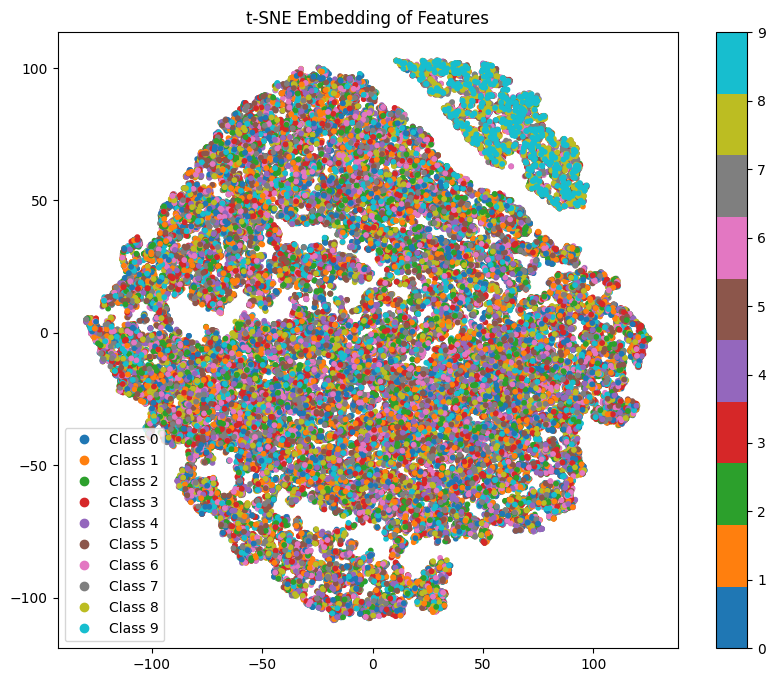

In [34]:

# Plot t-SNE embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=all_labels, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Class {i}' for i in range(num_classes)])
plt.title('t-SNE Embedding of Features')
plt.colorbar(scatter)
plt.show()


I swear the t-SNE was clearly working before, but while relaunching the script for a clean run the whole GAN did not perform as good as before.  DO NOT REMOVE POINTS.